In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Loading datasets:

In [269]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Briefly looking at train:

In [270]:
train.shape

(891, 12)

In [271]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


train dataset has 5 int type data columns, 5 object type data columns, and 2 float type data columns.

'Age' and 'Cabin' columns have null or missing values.

In [272]:
print("Percent of rows of the dataset with missing age values:",(train[train.Age.isna()].shape[0]/train.shape[0])*100)

Percent of rows of the dataset with missing age values: 19.865319865319865


In [273]:
print("Percent of rows of the dataset with missing Cabin values:",(train[train.Cabin.isna()].shape[0]/train.shape[0])*100)

Percent of rows of the dataset with missing Cabin values: 77.10437710437711


This suggests that although age missing values may be imputed, Cabin missing values may not be imputable.

In [274]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Briefly looking at test dataset:

In [275]:
test.shape

(418, 11)

In [276]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


test dataset has all columns of train dataset except 'Survived' column.

'Age' and 'Cabin' columns have null or missing values.

In [277]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Exploring and analysing train dataset:

<b><u>Univariate Analysis</u></b>

<b>Pclass</b> (ticket class)

In [278]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

<b>Name</b>

In [279]:
train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

<b>Sex</b>

In [280]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

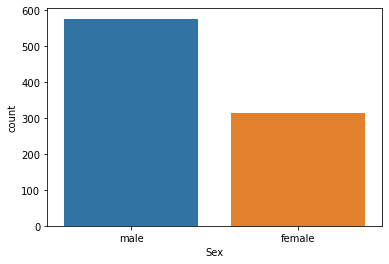

In [281]:
sns.countplot(x = train.Sex);

<b>Age</b>

In [282]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

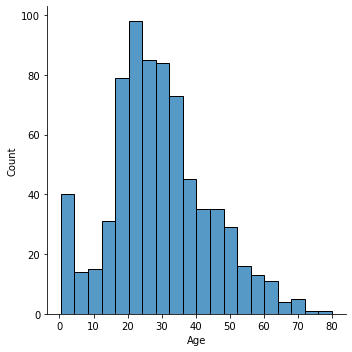

In [283]:
sns.displot(x = train.Age);

There are a lot of young children and middle aged people in the train dataset.

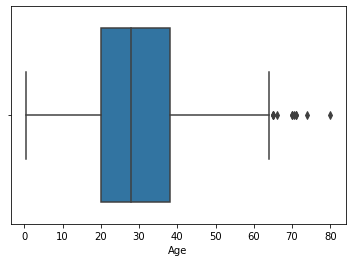

In [284]:
sns.boxplot(x = train.Age);

In [285]:
iqr = train.Age.describe()['75%'] - train.Age.describe()['25%']
upper = train.Age.describe()['75%'] + 1.5*iqr
lower = train.Age.describe()['25%'] - 1.5*iqr
print(iqr, lower, upper)

17.875 -6.6875 64.8125


In [286]:
train[train.Age > upper].shape

(11, 12)

In [287]:
train[train.Age > upper]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


Even though the ages above 64 are outliers, it just suggest that not many old people were on board the ship. (64-80 years of age is not really uncommon)

In [288]:
train[train.Age > upper]['Survived'].value_counts(normalize = True)

0    0.909091
1    0.090909
Name: Survived, dtype: float64

About 90% of the passengers who are outliers in terms of age do not survive.

<b>SibSp</b> (number of siblings or spouses)

In [289]:
train.SibSp.value_counts(normalize = True)

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

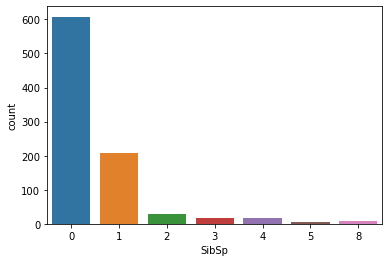

In [290]:
sns.countplot(x = train.SibSp);

The number of siblings or spouses for a passenger on board the ship was between 0 to 5 inclusive. Most passengers, about 68%, had no siblings or spouses. Only about 0.5% of the passengers had 5 siblings or spouses.

<b>Parch</b> (number of parents or children)

In [291]:
train.Parch.value_counts(normalize = True)

0    0.760943
1    0.132435
2    0.089787
3    0.005612
5    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

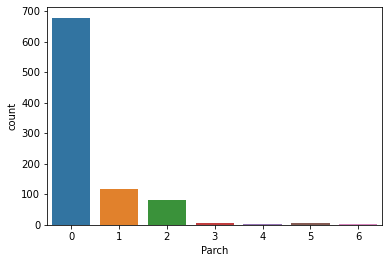

In [292]:
sns.countplot(x = train.Parch);

The number of parents or children on board the ship for a passenger was between 0 to 6 inclusive. Most passengers, about 76%, had no parents or children. Only 0.1% of the passengers has 6 parents or children.

<b>Ticket</b>

In [293]:
#must be treated like a categorical variable
train.Ticket.value_counts()

1601          7
CA. 2343      7
347082        7
3101295       6
347088        6
             ..
367232        1
27267         1
A/4. 20589    1
330979        1
349217        1
Name: Ticket, Length: 681, dtype: int64

In [294]:
len(train.Ticket.unique())

681

Many tickets are assigned to multiple passengers. 

<b>Fare</b>

In [295]:
len(train.Fare.value_counts())

248

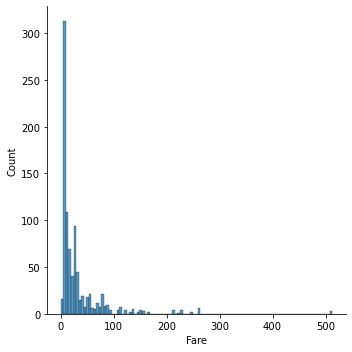

In [296]:
sns.displot(x = train.Fare);

The distribution of Fare is strongly right skewed. This suggests that most passengers travelled on cheaper fare.

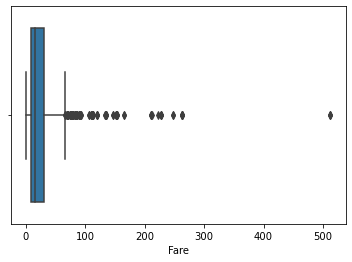

In [297]:
sns.boxplot(x = train.Fare);

In [298]:
iqr = train.Fare.describe()['75%'] - train.Fare.describe()['25%']
upper = train.Fare.describe()['75%'] + 1.5*iqr
lower = train.Fare.describe()['25%'] - 1.5*iqr
print(iqr, lower, upper)

23.0896 -26.724 65.6344


In [299]:
train[train.Fare > upper].shape

(116, 12)

In [300]:
train[train.Fare > upper]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S


Although there are 166 outliers in terms of fare payed, it must be expected since titanic was also ment to provide luxary for those who could afford it. 

In [301]:
train[train.Fare > upper]['Survived'].value_counts(normalize = True)

1    0.681034
0    0.318966
Name: Survived, dtype: float64

Most passengers, about 68%, who payed higher fare survived. 

<b>Cabin</b>

In [302]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
E101           3
              ..
E58            1
E12            1
E10            1
D15            1
C70            1
Name: Cabin, Length: 147, dtype: int64

There are 4 passengers who are assigned 3 cabins.

In [303]:
len(train.Cabin.value_counts())

147

<b>Embarked</b> Port of Embarkation

In [304]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

C = Cherbourg, Q = Queenstown, S = Southampton

<b><u>Bivarite Analysis</u></b>

<b>Survived and Pclass</b>

In [305]:
pd.crosstab(index = train.Survived, columns = train.Pclass, normalize = True, margins = True)

Pclass,1,2,3,All
Survived,,,,
0,0.089787,0.108866,0.417508,0.616162
1,0.152637,0.097643,0.133558,0.383838
All,0.242424,0.206510,0.551066,1.000000


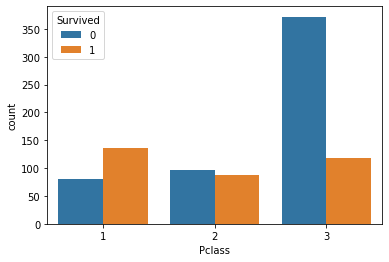

In [306]:
sns.countplot(x = train.Pclass, hue = train.Survived);

Most passengers in Class 1 survived whereas most passengers in Class 3 did not survive. Ratio of passengers who survived and who did not survive is almost equal in class 2.

<b>Survived and Sex</b>

In [307]:
pd.crosstab(index = train.Survived, columns = train.Sex, normalize = True, margins = True)

Sex,female,male,All
Survived,,,
0,0.090909,0.525253,0.616162
1,0.261504,0.122334,0.383838
All,0.352413,0.647587,1.000000


This shows that more females survived than males.

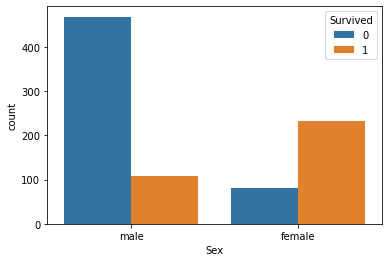

In [308]:
sns.countplot(x = train.Sex, hue = train.Survived);

<b>Survived and Age</b>

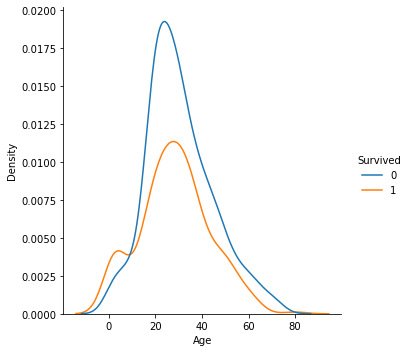

In [309]:
sns.displot(x = train.Age, hue = train.Survived, kind = 'kde');

The density plot for those who survived is above that of those who did not survive till the age of approximately 17. This suggests that younger passengers were more likely to survive.

<b>Survived and SibSp</b>

In [310]:
pd.crosstab(index = train.Survived, columns = train.SibSp, margins = True, normalize = True)

SibSp,0,1,2,3,4,5,8,All
Survived,,,,,,,,
0,0.446689,0.108866,0.016835,0.013468,0.016835,0.005612,0.007856,0.616162
1,0.235690,0.125701,0.014590,0.004489,0.003367,0.000000,0.000000,0.383838
All,0.682379,0.234568,0.031425,0.017957,0.020202,0.005612,0.007856,1.000000


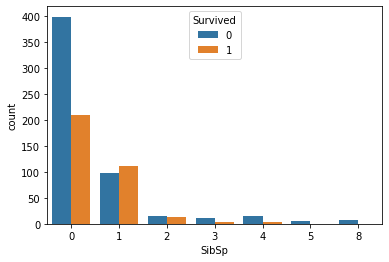

In [311]:
sns.countplot(x = train.SibSp, hue = train.Survived);

Most people with no siblings or spouses did not survive. Those who had 1 sibling or spouse mostly survided. Passengers with more than 1 sibling or spouses were more likely to not survive.

<b>Survived and Parch</b>

In [312]:
pd.crosstab(index = train.Survived, columns = train.Parch, margins = True, normalize = True)

Parch,0,1,2,3,4,5,6,All
Survived,,,,,,,,
0,0.499439,0.059484,0.044893,0.002245,0.004489,0.004489,0.001122,0.616162
1,0.261504,0.072952,0.044893,0.003367,0.000000,0.001122,0.000000,0.383838
All,0.760943,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122,1.000000


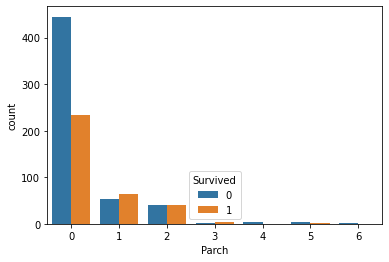

In [313]:
sns.countplot(x = train.Parch, hue = train.Survived);

Most people with no parents or children did not survive. Those having 1 or 2 parents or chidren were more likely to survive. Passengers with 3 or more than 3 parents or children were less likely to survive.

<b>Survived and Fare</b>

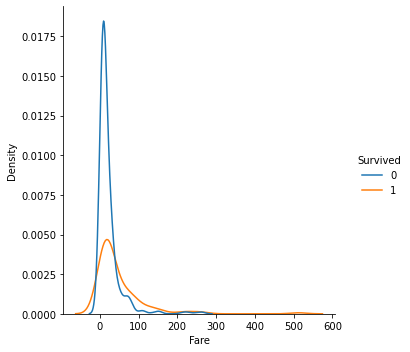

In [314]:
sns.displot(x = train.Fare, hue = train.Survived, kind = 'kde');

Passengers who paid higher fair were more likely to survive.

<b>Survived and Embarked</b>

In [315]:
pd.crosstab(index = train.Survived, columns = train.Embarked, margins = True, normalize = True)

Embarked,C,Q,S,All
Survived,,,,
0,0.084364,0.052868,0.480315,0.617548
1,0.104612,0.033746,0.244094,0.382452
All,0.188976,0.086614,0.724409,1.000000


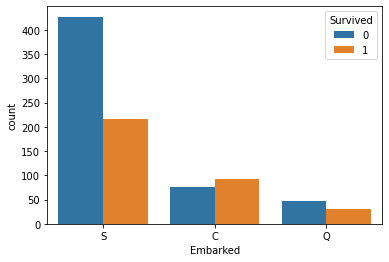

In [316]:
sns.countplot(x = train.Embarked, hue = train.Survived);

Passengers who embarked from S and Q were more likey to not survive.

### Missing value treatement

Dealing with Age:

In [317]:
no_age = train[train.Age.isnull()] #passengers with no age adata
no_age

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [318]:
no_age.Sex.value_counts()

male      124
female     53
Name: Sex, dtype: int64

In [319]:
no_age.Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [320]:
no_age.SibSp.value_counts()

0    137
1     26
8      7
3      4
2      3
Name: SibSp, dtype: int64

Among those whose age is missing, passengers with less co-passengers seem less likely to survive.

In [321]:
no_age.Parch.value_counts()

0    157
2     12
1      8
Name: Parch, dtype: int64

In [322]:
pd.crosstab(index = no_age.Survived, columns = no_age.Parch, margins = True, normalize = True)

Parch,0,1,2,All
Survived,,,,
0,0.621469,0.022599,0.062147,0.706215
1,0.265537,0.022599,0.005650,0.293785
All,0.887006,0.045198,0.067797,1.000000


Among those whose age is missing, passengers with less parents/children seem less likely to survive.

Missing age values can be replaced by the median of all age values.

Dealing with Ticket:

In [323]:
train.Ticket.value_counts().shape

(681,)

In [324]:
count = 0
for i in train.Ticket.value_counts():
    if i > 1:
        count = count + 1

In [325]:
print("In", train.Ticket.value_counts().shape[0], "unique tickets", count, "tickets are repeated.")

In 681 unique tickets 134 tickets are repeated.


In [326]:
print((count/train.Ticket.value_counts().shape[0])*100, "% tickets are repeated.")

19.676945668135097 % tickets are repeated.


In [327]:
just_numbers = [] #stores all ticket numbers that are totally numeric
alpha_numeric = [] #stores all ticket numbers that are alpha numeric
for i in train.Ticket.values:
    if i.isnumeric():
        just_numbers.append(i)
    else:
        alpha_numeric.append(i) 

In [328]:
len(just_numbers), len(alpha_numeric)

(661, 230)

In [329]:
len(set(just_numbers)), len(set(alpha_numeric))

(514, 167)

In [330]:
just_numbers = np.array(just_numbers, dtype = 'int32')

In [331]:
np.sort(just_numbers)

array([    693,     695,    1601,    1601,    1601,    1601,    1601,
          1601,    1601,    2003,    2223,    2620,    2623,    2624,
          2625,    2626,    2627,    2627,    2628,    2629,    2631,
          2641,    2647,    2648,    2649,    2650,    2651,    2651,
          2653,    2653,    2659,    2659,    2661,    2661,    2662,
          2663,    2664,    2665,    2665,    2666,    2666,    2666,
          2666,    2667,    2668,    2668,    2669,    2671,    2672,
          2674,    2677,    2678,    2678,    2680,    2683,    2685,
          2686,    2687,    2689,    2690,    2691,    2691,    2693,
          2694,    2695,    2697,    2699,    2699,    2700,    2908,
          2908,    2926,    3411,    3460,    3474,    4133,    4133,
          4133,    4133,    4134,    4135,    4136,    4137,    4138,
          4579,    5727,    6563,    7267,    7534,    7534,    7540,
          7545,    7546,    7552,    7553,    7598,    8471,    8475,
          9234,   11

The allocated numbers are not at all consistent.

In [332]:
alpha_numeric[0:20]

['A/5 21171',
 'PC 17599',
 'STON/O2. 3101282',
 'PP 9549',
 'A/5. 2151',
 'PC 17601',
 'PC 17569',
 'C.A. 24579',
 'PC 17604',
 'A./5. 2152',
 'SC/Paris 2123',
 'S.C./A.4. 23567',
 'A/4. 39886',
 'PC 17572',
 'C.A. 31026',
 'C.A. 34651',
 'CA 2144',
 'PC 17605',
 'C.A. 29395',
 'S.P. 3464']

There is a possibility that the only numeric tickets have missing alpha part. Usually ticket number are boarding specific.

In [333]:
#looking more closely are alpha-numeric tickets
number_part = []
other_part = []
for i in alpha_numeric:
    a = re.findall(r'\b[0-9]+$', i)
    if len(a) == 1:
        a = int(a[0])
        number_part.append(a)
        b = re.split(r'\b[0-9]+$', i)[0]
        other_part.append(b)
    else:
        print(re.split(r'\b[0-9]+$', i)[0])

LINE
LINE
LINE
LINE


In [334]:
other_part[0:6]

['A/5 ', 'PC ', 'STON/O2. ', 'PP ', 'A/5. ', 'PC ']

In [335]:
train[train.Ticket == 'LINE']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


There are 4 tickets with LINE written. All 4 of these tickets have been issued at S, all passengers here are males, theirs ages are atmost middle-age. Only 1 of these survived.

In [336]:
np.unique(other_part)

array(['A./5. ', 'A.5. ', 'A/4 ', 'A/4. ', 'A/5 ', 'A/5. ', 'A/S ',
       'A4. ', 'C ', 'C.A. ', 'C.A./SOTON ', 'CA ', 'CA. ', 'F.C. ',
       'F.C.C. ', 'Fa ', 'P/PP ', 'PC ', 'PP ', 'S.C./A.4. ',
       'S.C./PARIS ', 'S.O./P.P. ', 'S.O.C. ', 'S.O.P. ', 'S.P. ',
       'S.W./PP ', 'SC ', 'SC/AH ', 'SC/AH Basle ', 'SC/PARIS ',
       'SC/Paris ', 'SCO/W ', 'SO/C ', 'SOTON/O.Q. ', 'SOTON/O2 ',
       'SOTON/OQ ', 'STON/O 2. ', 'STON/O2. ', 'SW/PP ', 'W./C. ',
       'W.E.P. ', 'W/C ', 'WE/P '], dtype='<U12')

A lot of these differ only by the '.' or '/' symbols or white spaces. 

In [337]:
pd.Series(np.array(other_part)).value_counts()

PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
SOTON/O.Q.       8
CA.              8
SOTON/OQ         7
A/5.             7
CA               6
STON/O2.         6
SC/PARIS         5
S.O.C.           5
F.C.C.           5
C                5
SC/Paris         4
A/4              3
PP               3
A/4.             3
S.O./P.P.        3
S.C./PARIS       2
WE/P             2
P/PP             2
SC/AH            2
A./5.            2
SOTON/O2         2
A.5.             2
SO/C             1
SCO/W            1
S.W./PP          1
S.C./A.4.        1
A4.              1
C.A./SOTON       1
SW/PP            1
W/C              1
A/S              1
F.C.             1
W.E.P.           1
SC/AH Basle      1
SC               1
Fa               1
S.O.P.           1
S.P.             1
dtype: int64

Among the the tickets with letters and numbers, there are comparitively many tickets that have letters 'PC' in them. 

In [338]:
#getting a list of all ticket starting with PC
pc_tickets = []
for i, j in enumerate(train.Ticket.values):
    if j.startswith('PC'):
        pc_tickets.append(i)
    

In [339]:
train.iloc[pc_tickets, ]['Survived'].value_counts()

1    39
0    21
Name: Survived, dtype: int64

Most of the passengers with letters 'PC' on their ticket survived.

In [340]:
#getting a list of all ticket starting with C.A.
ca_tickets = []
for i, j in enumerate(train.Ticket.values):
    if j.startswith('C.A.'):
        ca_tickets.append(i)
    

In [341]:
train.iloc[ca_tickets, ]['Survived'].value_counts()

0    15
1    13
Name: Survived, dtype: int64

For passengers with letters 'C.A.' on their ticket, there is a fair split on the ratio of passenger who survived and who did not survive 

In [342]:
#getting a list of all ticket starting with CA.
ca_tickets = []
for i, j in enumerate(train.Ticket.values):
    if j.startswith('CA'):
        ca_tickets.append(i)

In [343]:
train.iloc[ca_tickets, ]['Survived'].value_counts()

0    13
1     1
Name: Survived, dtype: int64

For passengers with letters 'CA.' on their ticket, only 1 survived in 14.

In [344]:
train.iloc[ca_tickets, ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.90,NaN,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.90,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.90,NaN,S
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.55,NaN,S
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.90,NaN,S


In [345]:
train[train.Ticket == 'CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [346]:
train[train.Ticket == '347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


In [347]:
train[train.Ticket == '1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [348]:
train[train.Ticket == '3101295']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
824,825,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S


In [349]:
train[train.Ticket == '347088']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9,NaN,S
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9,NaN,S
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9,NaN,S
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,NaN,S
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9,NaN,S
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9,NaN,S


Ticket values do seem to be related to Survial somehow. The Ticket data needs to be cleaned for proper use.

In [350]:
ticket_code = []
ticket_num = []
for i in train.Ticket.values:
    num = re.findall(r'\b[0-9]+$', i)
    code = re.split(r'\b[0-9]+$', i)[0]
    ticket_code.append(code)
    if(len(num) == 0):
        ticket_num.append(np.nan)
    else:
        ticket_num.append(int(num[0]))
        

In [351]:
train['ticket_code'] = pd.Series(np.array(ticket_code))
train['ticket_num'] = pd.Series(np.array(ticket_num))

In [352]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ticket_code,ticket_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,,113803.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,,373450.0


In [353]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  ticket_code  891 non-null    object 
 13  ticket_num   887 non-null    float64
dtypes: float64(3), int64(5), object(6)
memory usage: 97.6+ KB


In [354]:
train.drop(['Ticket'], axis = 1, inplace = True)

There still are rows where ticket_num is missing.

In [355]:
train[train['ticket_num'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,ticket_code,ticket_num
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,0.0,NaN,S,LINE,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,0.0,NaN,S,LINE,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,0.0,NaN,S,LINE,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,0.0,NaN,S,LINE,NaN


In [356]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,ticket_code,ticket_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,A/5,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,PC,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,STON/O2.,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,,113803.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,,373450.0


In [357]:
def clean_ticket(s):
    s = s.lower()
    s = ''.join(w.strip() for w in s.split())
    s = re.sub(r'[^a-zA-Z0-9]', '', s)
    return s

In [358]:
train.ticket_code = train.ticket_code.apply(clean_ticket)

In [359]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,ticket_code,ticket_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,a5,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,pc,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,stono2,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,,113803.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,,373450.0


Dealing with Name:

Since survival of passengers has nothing to do with their name, it can be ignored.

In [360]:
train.drop(['Name'], axis = 1, inplace = True)

In [361]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,ticket_code,ticket_num
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,a5,21171.0
1,2,1,1,female,38.0,1,0,71.2833,C85,C,pc,17599.0
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,stono2,3101282.0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,,113803.0
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,,373450.0


Dealing with Cabin:

In [362]:
temp = train.Cabin.value_counts()

In [363]:
len(temp[temp > 1])

46

In [364]:
len(temp[temp == 1])

101

In [365]:
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Cabin does not provide enough data. It is best to remove the cabin data.

In [366]:
train.drop(['Cabin'], axis = 1, inplace = True)

In [367]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_code,ticket_num
0,1,0,3,male,22.0,1,0,7.2500,S,a5,21171.0
1,2,1,1,female,38.0,1,0,71.2833,C,pc,17599.0
2,3,1,3,female,26.0,0,0,7.9250,S,stono2,3101282.0
3,4,1,1,female,35.0,1,0,53.1000,S,,113803.0
4,5,0,3,male,35.0,0,0,8.0500,S,,373450.0


#### Strategy to deal with missing values

Replace missing age values by meidan value of age. Remove ticket data.

In [368]:
train.drop(['ticket_code', 'ticket_num', 'PassengerId'], axis = 1, inplace = True)

In [369]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [370]:
train[train['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [371]:
train.drop([61, 829], axis = 0, inplace = True)

In [372]:
train['Age'].fillna(train['Age'].median(), inplace = True)

In [373]:
#train['Pclass'] = train['Pclass'].astype('category')

In [374]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [375]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked'])

In [376]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [377]:
train.drop(['Sex_male'], axis = 1, inplace = True)

### Spliting data

In [378]:
X = train.drop(['Survived'], axis = 1)
y = train['Survived']

In [379]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         889 non-null    float64
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Fare        889 non-null    float64
 4   Pclass_1    889 non-null    uint8  
 5   Pclass_2    889 non-null    uint8  
 6   Pclass_3    889 non-null    uint8  
 7   Sex_female  889 non-null    uint8  
 8   Embarked_C  889 non-null    uint8  
 9   Embarked_Q  889 non-null    uint8  
 10  Embarked_S  889 non-null    uint8  
dtypes: float64(2), int64(2), uint8(7)
memory usage: 40.8 KB


In [381]:
y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

Fix imbalance:

In [382]:
resampler = TomekLinks()
X, y = resampler.fit_resample(X, y)

In [383]:
y.value_counts()

0    486
1    340
Name: Survived, dtype: int64

Scale X values:

In [384]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

In [386]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 1, test_size = 0.1)

### XGBoost model

In [387]:
xgb = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)

In [388]:
xgb_scores = cross_val_score(xgb, X_train, y_train)

In [389]:
xgb_scores

array([0.83193277, 0.79831933, 0.78151261, 0.83193277, 0.83898305])

In [390]:
xgb_scores.mean()

0.8165361059678109

In [391]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [392]:
xgb.score(X_train, y_train)

0.9663299663299664

In [393]:
xgb.score(X_val, y_val)

0.9090909090909091

In [394]:
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss', use_label_encoder = False, max_depth = 5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [395]:
xgb.score(X_train, y_train)

0.9562289562289562

In [396]:
xgb.score(X_val, y_val)

0.9242424242424242

In [397]:
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss', use_label_encoder = False, max_depth = 5, alpha = 1.2)
xgb.fit(X_train, y_train)

XGBClassifier(alpha=1.2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=1.20000005, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [398]:
xgb.score(X_train, y_train)

0.9191919191919192

In [399]:
xgb.score(X_val, y_val)

0.9545454545454546

In [400]:
pred = xgb.predict(X_test)

<AxesSubplot:>

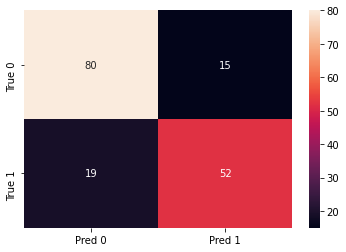

In [401]:
cm = confusion_matrix(y_test, pred, labels = [0, 1])
df_cm = pd.DataFrame(cm, index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])
sns.heatmap(df_cm, annot = True)

In [402]:
print(classification_report(y_test, pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        95
           1       0.78      0.73      0.75        71

    accuracy                           0.80       166
   macro avg       0.79      0.79      0.79       166
weighted avg       0.79      0.80      0.79       166



## Submission

In [403]:
test = pd.read_csv('test.csv')

In [404]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [405]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


1. remove ticket, Name and cabin data

In [406]:
test.drop(['Ticket', 'Cabin', 'Name'], axis = 1, inplace = True)

2. impute age missing values by median age

In [407]:
test['Age'].fillna(test['Age'].median(), inplace = True)

In [408]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


3. One-hot encode Pclass, Sex and Embarked

In [409]:
test = pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked'])

In [410]:
test.drop(['Sex_male'], axis = 1, inplace = True)

In [411]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         417 non-null    float64
 5   Pclass_1     418 non-null    uint8  
 6   Pclass_2     418 non-null    uint8  
 7   Pclass_3     418 non-null    uint8  
 8   Sex_female   418 non-null    uint8  
 9   Embarked_C   418 non-null    uint8  
 10  Embarked_Q   418 non-null    uint8  
 11  Embarked_S   418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(7)
memory usage: 19.3 KB


Impute missing fare value too

In [412]:
test['Fare'].fillna(test['Fare'].median(), inplace = True)

In [413]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Pclass_1     418 non-null    uint8  
 6   Pclass_2     418 non-null    uint8  
 7   Pclass_3     418 non-null    uint8  
 8   Sex_female   418 non-null    uint8  
 9   Embarked_C   418 non-null    uint8  
 10  Embarked_Q   418 non-null    uint8  
 11  Embarked_S   418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(7)
memory usage: 19.3 KB


In [414]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,0,0,7.8292,0,0,1,0,0,1,0
1,893,47.0,1,0,7.0000,0,0,1,1,0,0,1
2,894,62.0,0,0,9.6875,0,1,0,0,0,1,0
3,895,27.0,0,0,8.6625,0,0,1,0,0,0,1
4,896,22.0,1,1,12.2875,0,0,1,1,0,0,1


In [415]:
test.loc[:,'Age':] = scaler.transform(test.loc[:,'Age':])

In [416]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,892,0.428248,0.000,0.000000,0.015282,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,893,0.585323,0.125,0.000000,0.013663,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,894,0.773813,0.000,0.000000,0.018909,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,895,0.334004,0.000,0.000000,0.016908,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,896,0.271174,0.125,0.166667,0.023984,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [417]:
pred_list = []
for i in test.PassengerId:
    prediction = xgb.predict(test[test.PassengerId == i].loc[:,'Age':])[0]
    pred_list.append([i, prediction])

In [418]:
pred_list[0:3]

[[892, 0], [893, 0], [894, 0]]

In [419]:
pred_df = pd.DataFrame(np.array(pred_list), columns = ['PassengerId', 'Survived'])

In [420]:
pred_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [421]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int32
 1   Survived     418 non-null    int32
dtypes: int32(2)
memory usage: 3.4 KB


In [422]:
pred_df.to_csv('titanic_submission.csv', index = False)